In [1]:
import torch
import imp
import ppuu.costs

from ppuu.data.dataloader import DataStore, Dataset, Normalizer, UnitConverter
from ppuu import configs

store = DataStore('/home/us441/nvidia-collab/vlad/traffic-data-5/state-action-cost/data_i80_v0/')
ds = Dataset(store, 'train', 20, 30, 40, shift=False, random_actions=False)
loader = torch.utils.data.DataLoader(ds, batch_size=2)
normalizer = Normalizer(store.stats)

In [2]:
from ppuu.lightning_modules.fm import FM

m_config = FM.Config()
m_config.model.fm_type = "km_no_action"
m_config.model.checkpoint = "/home/us441/nvidia-collab/vlad/results/fm/km_no_action/fm_km_no_action_64/seed=42/checkpoints/last.ckpt"
m_config.training.enable_latent = True
m_config.training.diffs = False
forward_model = FM(m_config).cuda()
forward_model._setup_normalizer(store.stats)
forward_model.model.device = torch.device('cuda')

# Mock visualizer

In [3]:
from matplotlib import pyplot

class MockVisualizer:
    
    def __init__(self):
        self.vals = {}
        
        
    def update_val(self, val):
        self.val = val
        self.vals[val] = {}
        self.vals[val]['costs_history'] = []
        self.vals[val]['acc_history'] = []
        self.vals[val]['turn_history'] = []
        self.vals[val]['acc_grad_history'] = []
        self.vals[val]['turn_grad_history'] = []
    
    def update_plot(self):
        pass
    
    def reset(self):
        pass
    
    def step_reset(self):
        pass
    
    def update_values(self, cost, acc, turn, acc_grad=0, turn_grad=0):
        self.vals[self.val]['costs_history'].append(cost)
        self.vals[self.val]['acc_history'].append(acc)
        self.vals[self.val]['turn_history'].append(turn)
        self.vals[self.val]['acc_grad_history'].append(acc_grad)
        self.vals[self.val]['turn_grad_history'].append(turn_grad)
        
    def plot(self):
        plt.figure(dpi=200, figsize=(15, 15))

        for i, k in enumerate(['costs_history', 'acc_history', 'turn_history', 'acc_grad_history', 'turn_grad_history']):
            plt.subplot(5, 1, i + 1)
            for v in self.vals:
                plt.plot(self.vals[v][k], label=v)
            plt.legend()
            plt.title(k)
                
        
visualizer = MockVisualizer()

# FM mpc init

In [4]:
from ppuu.data import NGSIMDataModule

datamodule = NGSIMDataModule(
        '/home/us441/nvidia-collab/vlad/traffic-data-5/state-action-cost/data_i80_v0/',
        100,
        100,
        6,
        workers=0,
        diffs=False,
        npred=30,
    )
datamodule.setup()

In [5]:
from ppuu.modeling.mpc import MPCFMPolicy

# Type = ppuu.costs.PolicyCostContinuous
Type = ppuu.costs.PolicyCost

fm_cost_config = Type.Config()
fm_cost_config.lambda_l = 0
fm_cost_config.skip_contours = True
fm_cost_config.u_reg = 0.2
fm_cost = Type(fm_cost_config, forward_model.model, normalizer)
fm_cost.estimate_uncertainty_stats(datamodule.train_dataloader())

[estimating normal uncertainty ranges: 100.0%]


In [6]:
fm_mpc_config = MPCFMPolicy.Config()
fm_mpc_config.lr = 0.1 
fm_mpc_config.n_iter = 10
fm_mpc_config.optimizer = 'Adam'
fm_mpc_config.save_opt_stats = True

fm_mpc = MPCFMPolicy(forward_model, fm_cost, normalizer, fm_mpc_config, visualizer)

# KM mpc init

In [7]:
from ppuu.modeling.mpc import MPCKMPolicy

km_cost_config = ppuu.costs.PolicyCostKMTaper.Config()
km_cost_config.u_reg = 0
km_cost = ppuu.costs.PolicyCostKMTaper(km_cost_config, None, normalizer)
km_mpc_config = MPCKMPolicy.Config(batch_size=3, 
                                   fm_unfold_samples=3, 
                                   fm_unfold_samples_agg='max', 
                                   lambda_j_mpc=0.1,
                                   lr=0.481,
                                   n_iter=27,
                                   unfold_len=30,
                                   unfolding_agg='max',
                                   optimizer='SGD',
                                  )
km_mpc = MPCKMPolicy(forward_model, km_cost, normalizer, km_mpc_config, visualizer)

# Get batch

In [8]:
it = iter(loader)

In [9]:
batch = next(it)
print(batch['input_images'].shape)
print(batch['ego_cars'].shape)

torch.Size([2, 20, 3, 117, 24])
torch.Size([2, 3, 117, 24])


In [10]:
print(batch['input_states'])

tensor([[[-6.1939e-01, -1.6161e+00,  4.3119e-02,  3.6989e-01,  4.1804e+00],
         [-5.8405e-01, -1.6143e+00,  4.5723e-02,  3.3343e-01,  4.1885e+00],
         [-5.4865e-01, -1.6128e+00,  4.7954e-02,  2.9068e-01,  4.1969e+00],
         [-5.1320e-01, -1.6119e+00,  4.9535e-02,  2.3211e-01,  4.2066e+00],
         [-4.7769e-01, -1.6116e+00,  4.9302e-02,  1.6660e-01,  4.2184e+00],
         [-4.4210e-01, -1.6121e+00,  4.6164e-02,  8.7115e-02,  4.2321e+00],
         [-4.0644e-01, -1.6134e+00,  3.9493e-02,  3.2913e-03,  4.2466e+00],
         [-3.7068e-01, -1.6157e+00,  3.0195e-02, -7.4366e-02,  4.2602e+00],
         [-3.3483e-01, -1.6189e+00,  2.0316e-02, -1.3817e-01,  4.2711e+00],
         [-2.9892e-01, -1.6228e+00,  9.0887e-03, -1.9881e-01,  4.2788e+00],
         [-2.6297e-01, -1.6275e+00, -8.3681e-04, -2.4559e-01,  4.2842e+00],
         [-2.2698e-01, -1.6326e+00, -1.1762e-02, -2.9207e-01,  4.2890e+00],
         [-1.9096e-01, -1.6383e+00, -1.9828e-02, -3.2383e-01,  4.2938e+00],
         [-1

torch.Size([2, 2])


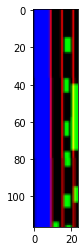

In [11]:
from matplotlib import pyplot as plt
plt.imshow(batch['input_images'][0][0].permute(1, 2, 0))
print(batch['car_sizes'].shape)

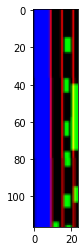

In [12]:
modified_images = batch['input_images'].clone() #torch.zeros_like(batch['input_images'])

# car_slice = slice(13, 20) # to the right
# car_slice = slice(4, 11) # to the left
car_slice = slice(0, 24)
car_slice_x = slice(65, 85) # behind
# car_slice_x = slice(40, 55) # in front
# car_slice_x = slice(0, 117) # everywhere
# modified_images[:, :, 1, car_slice_x, car_slice] = 1

# modified_images = batch['input_images'] # torch.zeros_like(batch['input_images'])
plt.imshow(modified_images[0][0].permute(1, 2, 0))

In [13]:
input_images = modified_images[0]
input_car = batch['ego_cars'][0].sum(dim=0).unsqueeze(0).repeat(input_images.shape[0], 1, 1, 1)
input_images_with_car = torch.cat([input_images, input_car], dim=1)
print(input_images_with_car.shape)

torch.Size([20, 4, 117, 24])


In [14]:
visualizer.update_val('fm')
metadata = {'pred_images':[], 'pred_states':[], 'costs':[], 'predictions':[]}
fm_actions = fm_mpc(input_images_with_car.cuda(), batch['input_states'][0].cuda(), normalize_inputs=False, car_size=batch['car_sizes'][0].cuda().unsqueeze(0), metadata=metadata)

final actions for 0 are tensor([[-0.2381, -0.4023]], device='cuda:0', grad_fn=<SelectBackward>)


In [15]:
visualizer.update_val('km')
km_actions = km_mpc(input_images_with_car.cuda(), batch['input_states'][0].cuda(), normalize_inputs=False, car_size=batch['car_sizes'][0].cuda().unsqueeze(0))

final actions for 0 are tensor([[-0.0458, -0.6447]], device='cuda:0', grad_fn=<SelectBackward>)


# Plotting

<Figure size 1200x800 with 0 Axes>

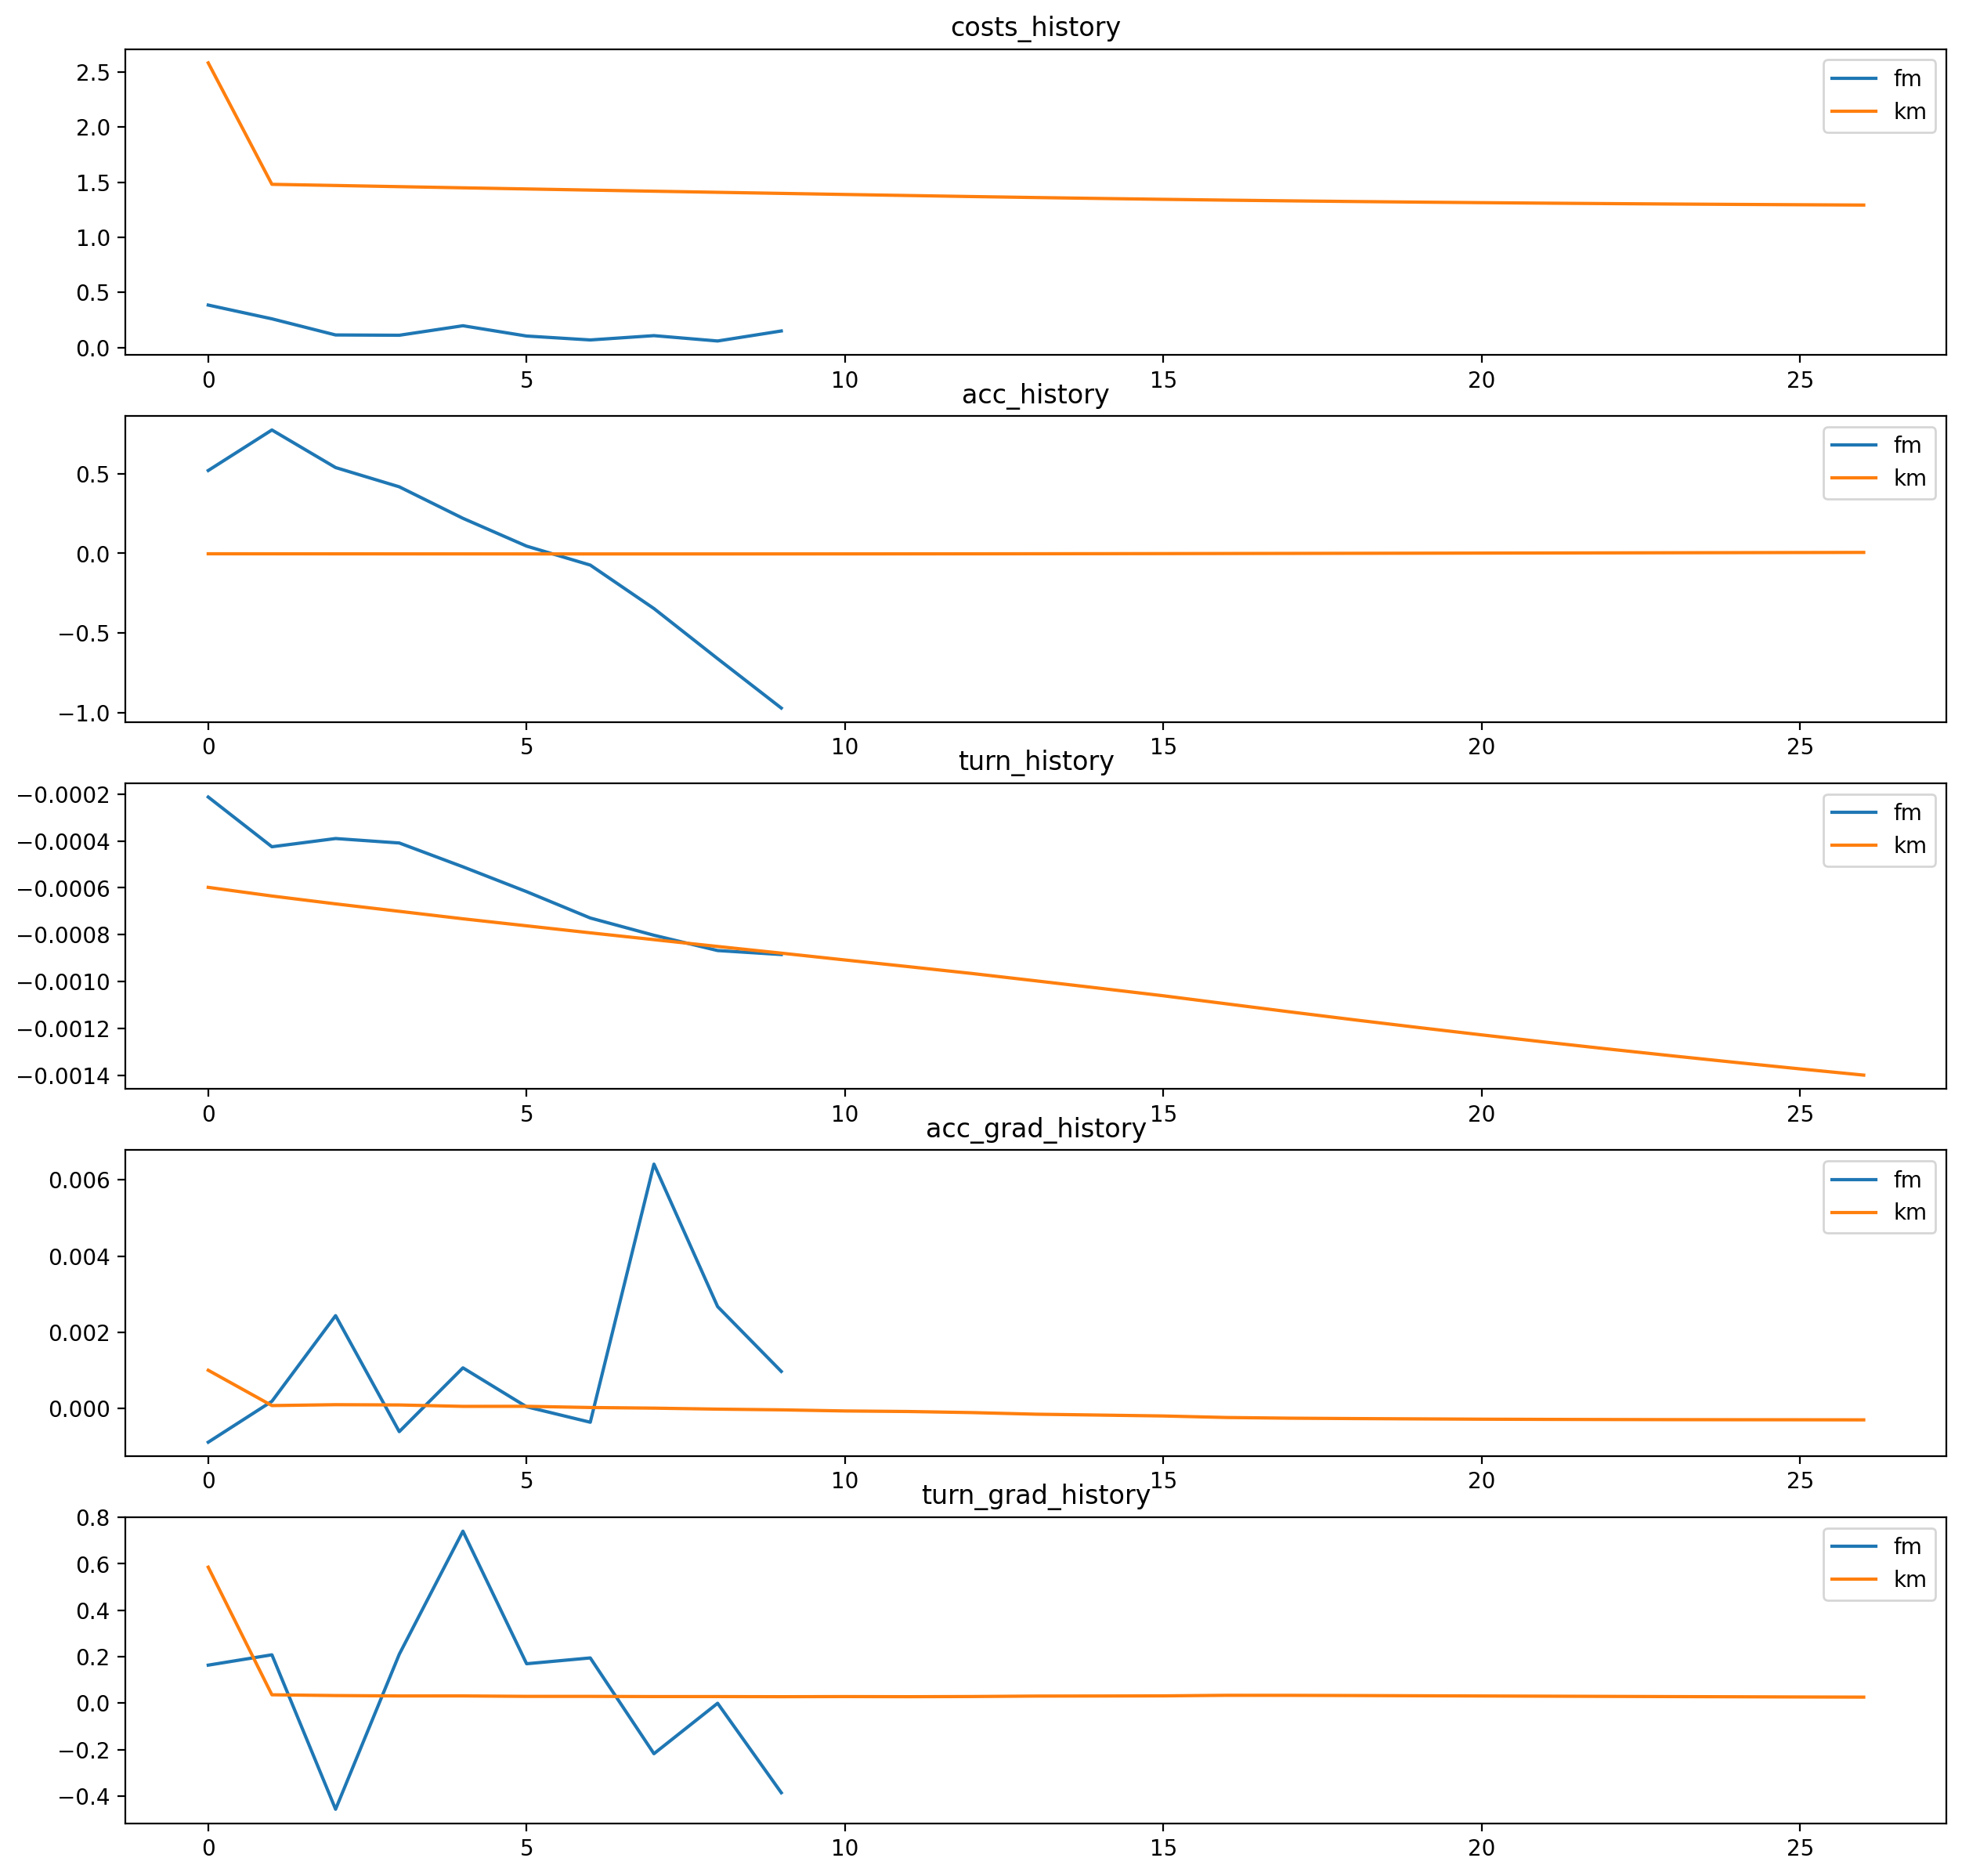

In [16]:
plt.figure(dpi=200)
visualizer.plot()

In [17]:
metadata.keys()

dict_keys(['pred_images', 'pred_states', 'costs', 'predictions'])

In [18]:
metadata['pred_images'][0].shape

torch.Size([1, 30, 3, 117, 24])

IndexError: list index out of range

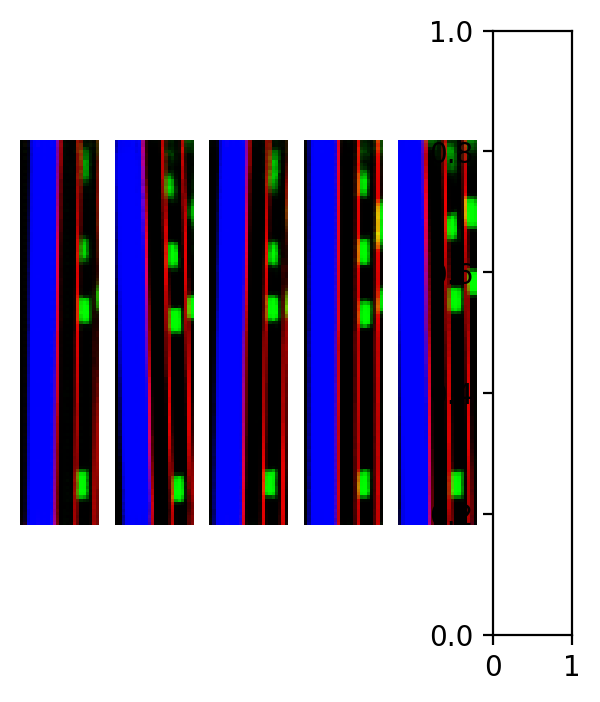

In [19]:
plt.figure(dpi=200)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(metadata['pred_images'][2*i][0][19].permute(1, 2, 0).detach().cpu())
    plt.axis('off')

In [ ]:
def plt_cost(name):
    pl = [x[name].item() for x in metadata['costs']]
    plt.plot(pl)

In [ ]:
plt.figure(dpi=200)
plt.subplot(3, 1, 1)
plt.title('total')
plt_cost('policy_loss')
plt.subplot(3, 1, 2)
plt.title('proximity')
plt_cost('proximity_loss')
plt.subplot(3, 1, 3)
plt.title('lane')
plt_cost('lane_loss')
plt.tight_layout()

# Analyze metadata

In [20]:
# making sure all z's are the same
print(metadata['predictions'][0]['Z'].abs().sum())
print(metadata['predictions'][1]['Z'].abs().sum())
print(metadata['predictions'][-1]['Z'].abs().sum())

tensor(754.9244, device='cuda:0')
tensor(754.9244, device='cuda:0')
tensor(754.9244, device='cuda:0')


In [21]:
# check that distribution is good
print(metadata['predictions'][-1]['Z'].std())
print(metadata['predictions'][-1]['Z'].mean())

tensor(0.9774, device='cuda:0')
tensor(-0.0003, device='cuda:0')


In [23]:
# check resulting actions
print(metadata['predictions'][0]['pred_actions'])

tensor([[[-0.0446,  0.0143],
         [-0.0488,  0.0143],
         [-0.0440,  0.0143],
         [-0.0457,  0.0143],
         [-0.0421,  0.0143],
         [-0.0454,  0.0143],
         [-0.0445,  0.0143],
         [-0.0476,  0.0143],
         [-0.0452,  0.0143],
         [-0.0470,  0.0143],
         [-0.0455,  0.0143],
         [-0.0491,  0.0143],
         [-0.0451,  0.0143],
         [-0.0468,  0.0143],
         [-0.0488,  0.0143],
         [-0.0476,  0.0143],
         [-0.0478,  0.0143],
         [-0.0471,  0.0143],
         [-0.0465,  0.0143],
         [-0.0440,  0.0143],
         [-0.0432,  0.0143],
         [-0.0436,  0.0143],
         [-0.0476,  0.0143],
         [-0.0486,  0.0143],
         [-0.0483,  0.0143],
         [-0.0462,  0.0143],
         [-0.0487,  0.0143],
         [-0.0463,  0.0143],
         [-0.0455,  0.0143],
         [-0.0448,  0.0143]]], device='cuda:0', grad_fn=<RepeatBackward>)
